<a href="https://colab.research.google.com/github/mbilalnust/book_recommendation_nearest_neighbor/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [51]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-06-09 08:29:57--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M  --.-KB/s    in 0.1s    

2025-06-09 08:29:57 (208 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Book-Ratings.csv     
replace BX-Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Books.csv            
replace BX-Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Users.csv            


In [53]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [54]:
print(df_books.head())
print(df_ratings.head())

         isbn                                              title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 author  
0    Mark P. O. Morford  
1  Richard Bruce Wright  
2          Carlo D'Este  
3      Gina Bari Kolata  
4       E. J. W. Barber  
     user        isbn  rating
0  276725  034545104X     0.0
1  276726  0155061224     5.0
2  276727  0446520802     0.0
3  276729  052165615X     3.0
4  276729  0521795028     6.0


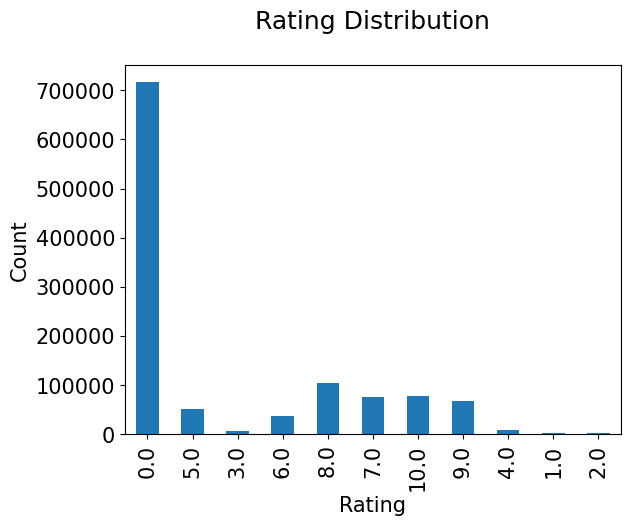

In [32]:
# prompt: no. i want to have histogram of count of ratings

import matplotlib.pyplot as plt
plt.rc("font", size=15)
df_ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [55]:
# prompt: i want to remove books with less than 100 ratings. Use df_ratings dataset.
# Count ratings per user and book
# Filter out users and books with too few ratings
user_counts = df_ratings['user'].value_counts()
book_counts = df_ratings['isbn'].value_counts()

df_ratings = df_ratings[df_ratings['user'].isin(user_counts[user_counts >= 200].index)]
df_ratings = df_ratings[df_ratings['isbn'].isin(book_counts[book_counts >= 100].index)]

In [56]:
# Create user-item matrix using your column names
df_book_features = df_ratings.pivot(index='isbn', columns='user', values='rating').fillna(0)
mat_book_features = csr_matrix(df_book_features.values)

In [57]:
df_book_features.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In many real-world scenarios (especially in areas like machine learning, natural language processing, and recommendation systems), you often have very large matrices with mostly zero values (i.e., sparse data). Storing all those zeros is inefficient in terms of memory and computation.

csr_matrix solves this by storing only the non-zero elements and their indices.

In [58]:
#Modeling and Training
# Train KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
model_knn.fit(mat_book_features)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [94]:
# Function to get recommendations
def get_recommends(book=""):
    title = book
    try:
        book_row = df_books[df_books['title'] == book]
        if book_row.empty:
            return [title, []]

        isbn = book_row.iloc[0]['isbn']
        idx = df_book_features.index.get_loc(isbn)
        distances, indices = model_knn.kneighbors(mat_book_features[idx], n_neighbors=6)

        recommended_books = []
        for i in range(1, 6):  # skip the book itself
            recommended_isbn = df_book_features.index[indices.flatten()[i]]
            recommended_title = df_books[df_books['isbn'] == recommended_isbn]['title'].values[0]
            distance = round(float(distances.flatten()[i]), 2)
            recommended_books.append([recommended_title, distance])

        # Sort by similarity DESC, then title ASC
        recommended_books.sort(key=lambda x: x[1], reverse=True)

        return [title, recommended_books[0:4]]
    except Exception as e:
        return [title, []]



In [95]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8], ['I Know This Much Is True', 0.77], ['The Surgeon', 0.77], ['The Weight of Water', 0.77]]]


In [96]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'I Know This Much Is True','The Surgeon','The Weight of Water']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8], ['I Know This Much Is True', 0.77], ['The Surgeon', 0.77], ['The Weight of Water', 0.77]]]
You passed the challenge! 🎉🎉🎉🎉🎉
